Visualize the data of the Monte Carlo experiment (matrices A and B). Compute statistics of the output.

In [178]:
import memilio.simulation.secir as secir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, date
import time
import seaborn as sns
plt.style.use("seaborn")

import scipy.stats

import plotly.graph_objects as go

from __future__ import print_function
import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)

import pickle
import json

In [179]:
path_simulation_result = 'Studies/Sobol_MC_50000_InfectedDead.pkl'
path_data = 'data/worldometer_data.txt'

# Define Comartment names
compartments = ['susceptible', 'exposed', 'carrier', 'infected', 'hospitalized', 'icu', 'recovered', 'dead']
Compartments = ['Susceptible', 'Exposed', 'Carrier', 'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']


In [180]:
# load simulation
with open(path_simulation_result, 'rb') as f:
    size = pickle.load(f)
    input_factor_names = pickle.load(f)
    distributions = pickle.load(f) # saved as coll (collection of distributions)
    static_params = pickle.load(f)
    inputDesign = pickle.load(f)
    sim_out = pickle.load(f)
    runtime = pickle.load(f)

In [181]:
print(f"Size of Monte Carlo experiment is {size}.")
print(f"The Monte Carlo experiment needed {runtime} s.")
print(f"{len(input_factor_names)} input factors were used.")
print(f"The model was simulated {len(sim_out)} times.")
print("Static params: ", static_params)
#print(f"Considered input factors are {input_factor_names}")

Size of Monte Carlo experiment is 50000.
The Monte Carlo experiment needed 20584.82719063759 s.
80 input factors were used.
The model was simulated 4100000 times.
Static params:  {'num_groups': 6, 'num_compartments': 8, 'populations': [40000, 70000, 190000, 290000, 180000, 60000], 'start_day': 77, 'days': 100, 'dt': 0.1, 'output_index': [3, 7], 'output_operation': 'all'}


In [182]:
sim_out.shape

(4100000, 101, 2)

### Choose number of days:

In [183]:
number_of_days = static_params['days']
print(number_of_days)

100


Load dataset for the correct time period.

In [184]:
# load data

start_dataset = 32
print(data_dict['categories'][start_dataset])

data_dict = {}
with open(path_data) as f:
    lines = f.readlines()
    #data_dict.update(lines[0])
    print(lines[-1])
    for i in range(len(lines)-1):
        (key, value) = lines[i].split(":")
        value = json.loads(value)
        data_dict[key] = value
print(data_dict.keys())

# when used for a different time period, initial numbers must be matched first. 
# Saved simulation is from start day 0, therefore no initial numbers in Hospitalized, Infected and Recovered
# Divide by 100 because of the population size used in the model
dataset = np.zeros((number_of_days+1, len(static_params['output_index'])))
dataset[:, 0] = np.array(data_dict['currently_infected'][start_dataset:number_of_days+1+start_dataset])/100.0
dataset[:, 1] = np.array(data_dict['total_deaths'][start_dataset:number_of_days+1+start_dataset])/100.0

Mar 18, 2020
source : "https://www.worldometers.info/coronavirus/country/germany/#graph-deaths-daily"

dict_keys(['categories', 'currently_infected', 'total_deaths', 'new_recoveries'])


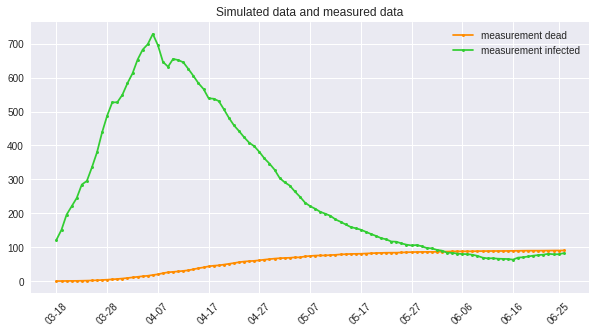

In [285]:
days = 100

dead_cases = np.array(data_dict['total_deaths'][start_dataset:number_of_days+1+start_dataset])/100.0
infected_cases = np.array(data_dict['currently_infected'][start_dataset:number_of_days+1+start_dataset])/100.0

df=pd.read_csv('death_confirmed_recovered.csv', sep=',')
df = (df.T).set_axis(['dead', 'confirmed', 'recovered'], axis=1, inplace=False)

date = str(start_month)+'/'+str(start_day)+'/'+ str(start_year)[2:]
date_index = df.index.get_loc(date)

dead_cases2 = np.squeeze(df["dead"].iloc[date_index:date_index+days+1].values)/100.0
confirmed_cases2 = np.squeeze(df["confirmed"].iloc[date_index:date_index+days+1].values)/100.0
recovered_cases2 = np.squeeze(df["recovered"].iloc[date_index:date_index+days+1].values)/100.0
#print("best values: ", best_values)
#static_params['output_index'] = [Compartments.index("Dead"), Compartments.index("Infected"), Compartments.index("Recovered")]
#simulation = simulate_model({**static_params, **dict(zip(input_factor_names, best_values))})
#print(simulation.shape)

datelist = np.array(pd.date_range(datetime(start_year, start_month,
                        start_day), periods=days, freq='D').strftime('%m-%d').tolist())

tick_range = (np.arange(int(days / 10) + 1) * 10)
tick_range[-1] -= 1
fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(simulation[:, 0], 'o-', markersize = 3, label='simulation dead', color="darkorange") 
#ax.plot(simulation[:, 1], 'o-', markersize = 3, label='simulation infected', color="darkgreen") 
#ax.plot(simulation[:, 2], 'o-', markersize = 3, label='simulation recovered', color="navy") 
ax.plot(dead_cases, 'o-', markersize = 3, label='measurement dead', color = "darkorange")
ax.plot((infected_cases), 'o-', markersize = 3, label='measurement infected', color = "limegreen")
#ax.plot(recovered_cases, 'o-', markersize = 3, label='measurement recovered', color = "royalblue")
#ax.plot(dead_cases2, '-', markersize = 3, label='measurement dead2', color = "darkorange")
#ax.plot(confirmed_cases2, 'o-', markersize = 3, label='measurement infected2', color = "darkgreen")
#ax.plot(recovered_cases2, 'o-', markersize = 3, label='measurement recovered2', color = "navy")
ax.set_title("Simulated data and measured data")
ax.set_xticks(tick_range)
ax.set_xticklabels(datelist[tick_range], rotation=45)
ax.legend()
fig.tight_layout
plt.show()

In [213]:
def aggregate_output(aggregation_function, output_no, number_of_days = number_of_days):

    if aggregation_function == "max":
        output_agg = np.max(sim_out[:, :number_of_days, output_no], axis = 1, keepdims = True)
    elif aggregation_function == "sum":
        output_agg = np.sum(sim_out[:, :number_of_days, output_no], axis = 1, keepdims=True)
    elif aggregation_function == "mean":
        output_agg = np.mean(sim_out[:, :number_of_days, output_no], axis = 1, keepdims=True)
    elif aggregation_function == "mse":
        output_agg = ((np.array(sim_out[:, :number_of_days, output_no]) - dataset[:number_of_days, output_no])**2).mean(axis = 1, keepdims = True)
    #print(f"Aggregated output is {aggregation_function} {output_compartment}.")
    return output_agg

In [186]:
def get_output_name(aggregation_function, output_no):
    out_comp = compartments[static_params['output_index'][output_no]]
    return f"{aggregation_function} {out_comp}"

In [190]:
# create list which contains all outputs of interest
outputs = []
output_names = []
for agg in ["max", "mse", 'mean']:
    for out_id in [0, 1]:
        if agg=='mean' and out_id==1:
            continue
        out_comp = compartments[static_params['output_index'][out_id]]
        print(f"Aggregated output is {agg} {out_comp}.")
        outputs.append(aggregate_output(agg, out_id))
        output_names.append(f"{agg} {out_comp}")
print(len(outputs))       
print(output_names)

Aggregated output is max infected.
Aggregated output is max dead.
Aggregated output is mse infected.
Aggregated output is mse dead.
Aggregated output is mean infected.
5
['max infected', 'max dead', 'mse infected', 'mse dead', 'mean infected']


In [268]:
def show_output_distribution(output_all, ids_to_plot, output_compartment, alpha_sim = 0.3, observation_data = None):
    '''
    output_all: A and B of the simulation output. This corresponds to the first 2N rows.
    ids_to_plot: list of random indices
    alpha: alpha values of the simulation plot (choose smaller alpha if many simulations are displayed)
    output_compartment: name of the output, for annotating the plot
    '''
    n_outputs = len(ids_to_plot)
    output_subset = np.transpose(output_all[ids_to_plot, :])
    title = f"SECIR simulation results for: {output_compartment}"

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10), tight_layout = True)
    fig.suptitle(title, fontsize = 15)

    days = output_all.shape[1]+1
    start_day = 18
    start_month = 3
    start_year = 2020
    
    num_time_points = days - 1
    
    x = np.arange(num_time_points)
    

    # Plot Results
    datelist = np.array(
        pd.date_range(
            datetime(start_year, start_month, start_day),
            periods=days, freq='D').strftime('%m-%d').tolist())

    tick_range = (np.arange(int(days / 10) + 1) * 10)
    tick_range[-1] -= 1

    axs[0, 0].plot(output_subset, alpha=alpha_sim )

    axs[0, 0].set_title(f"{n_outputs} of total {len(output_all)} simulations (randomly chosen)")

    mean_result = np.mean(output_all, axis = 0) 
    #n = len(data)
    #ci_result = np.array([scipy.stats.sem(data[:, i]) * scipy.stats.t.ppf((1+conf)/2., n-1) for i in range(num_time_points)])
    std_result = np.std(output_all, axis = 0) 

    median_result = np.quantile(output_all, q = 0.5, axis = 0) 
    print(median_result.min(), median_result.max())
    low_quantile_result = np.quantile(output_all, q = 0.25, axis = 0) 
    high_quantile_result = np.quantile(output_all, q = 0.75, axis = 0) 

    kurtosis_result = scipy.stats.kurtosis(output_all, axis = 0) 
    skew_result = scipy.stats.skew(output_all, axis = 0) 

    min_result = np.min(output_all, axis = 0) 
    max_result = np.max(output_all, axis = 0)  
    print(max_result.min(), max_result.max(), max_result[-1])
    print(np.argmax(max_result))

    axs[0, 1].plot(x, max_result, label = 'max')
    axs[0, 1].plot(x, high_quantile_result, label = '0.75 quantile')
    axs[0, 1].plot(x, median_result, label = 'median')
    axs[0, 1].plot(x, low_quantile_result, label = '0.25 quantile')
    axs[0, 1].plot(x, min_result, label = "min")
    axs[0, 1].plot(x, mean_result, label = 'mean')
    axs[0, 1].fill_between(x, 
                        (mean_result - std_result), (mean_result + std_result), 
                        color = 'b', alpha = .1, label = "std")

    #axs[1].fill_between(x, (mean_result - ci_result), (mean_result + ci_result), color = 'b', alpha = .1)
    #axs[1].set_title(f"Daywise mean with {conf} confidence interval.")
    axs[0, 1].set_title(f"Daywise min, max, mean and standard deviation of {len(output_all)} simulations")

    axs[1, 0].plot(skew_result, label = 'skew')
    axs[1, 0].set_title(f"Daywise skewdness (measure of the asymmetry)")
    axs[1, 1].plot(kurtosis_result, label = 'kurtosis')
    axs[1, 1].set_title(f"Daywise kurtosis (measure of the tailedness)")

    for j in range(2):
        for k in range(2):            
            axs[j, k].set_xticks(tick_range)
            axs[j, k].set_xticklabels(datelist[tick_range], rotation=45)           
            axs[0, k].set(ylabel = "Number of people", xlabel = "Date")
    axs[1, 0].set(ylabel = "Kurtosis", xlabel = "Date")
    axs[1, 1].set(ylabel = "Skew", xlabel = "Date")
    
    if observation_data is not None:
        axs[0, 0].plot(observation_data, c= 'black', label = 'observation')
        axs[0, 1].plot(observation_data, c= 'black', label = 'observation')
        axs[0, 0].legend()
    axs[0, 1].legend()
    plt.show()

def show_histogram_aggregated_output(output_agg, aggregation_function):
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 6), tight_layout = True)
    fig.suptitle(f"Histogram of aggregated simulation output: {aggregation_function}", fontsize = 15)
    axs[0].hist(output_agg, bins = 100, density = False, log = False)
    axs[0].set(xlabel = aggregation_function, 
              ylabel = "number of simulations")
    axs[1].hist(output_agg, bins = 100, density = False, log = True)
    axs[1].set(xlabel = aggregation_function, 
              ylabel = "log scaled number of simulations")
    plt.show()

In [269]:
outputs[0].shape

(4100000, 1)

In [262]:
def get_stats_df(outputs, output_names, N):
    df = pd.DataFrame()
    for name, out in zip(output_names, outputs):
        out = np.squeeze(out[:N])
        df_infection_peak = pd.DataFrame({name: out})

        df_infection_peak_summary = df_infection_peak.describe()
        df_infection_peak_summary.loc['var']=[np.var(out) ]
        df_infection_peak_summary.loc['kurtosis']=[scipy.stats.kurtosis(out) ]
        df_infection_peak_summary.loc['skew']=[scipy.stats.skew(out) ]
        df_infection_peak_summary.style.format("{:.2f}")
        df[name]=df_infection_peak_summary[name]
    return df

In [246]:
df_summary = get_stats_df(outputs, output_names, 2*size)

In [255]:
df_summary.loc[['min', 'max', 'mean', 'std', 'var', 'skew', 'kurtosis']].style.format("{:.2f}").to_latex()

'\\begin{tabular}{lrrrrr}\n & max infected & max dead & mse infected & mse dead & mean infected \\\\\nmin & 120.01 & 3.20 & 583.72 & 88.01 & 12.25 \\\\\nmax & 254322.39 & 17442.56 & 9526332492.23 & 91020706.30 & 58189.58 \\\\\nmean & 49187.60 & 2418.35 & 1168819125.93 & 3161398.52 & 15460.00 \\\\\nstd & 58060.91 & 3149.61 & 1766137228.03 & 6946928.49 & 17178.56 \\\\\nvar & 3371035288.46 & 9919916.27 & 3119209515827175424.00 & 48259332840847.42 & 295100059.55 \\\\\nskew & 0.97 & 1.30 & 1.54 & 3.34 & 0.74 \\\\\nkurtosis & -0.31 & 0.66 & 1.52 & 14.29 & -0.99 \\\\\n\\end{tabular}\n'

In [199]:
N = size
n_outputs = 20# must be smaller than 2N

randidx = np.sort(np.random.randint(0, 2*N, n_outputs))

# Prediction of infection numbers

125.00260904687903 7416.828836826662
129.99978659684714 254322.38729087217 179565.24108116422
29


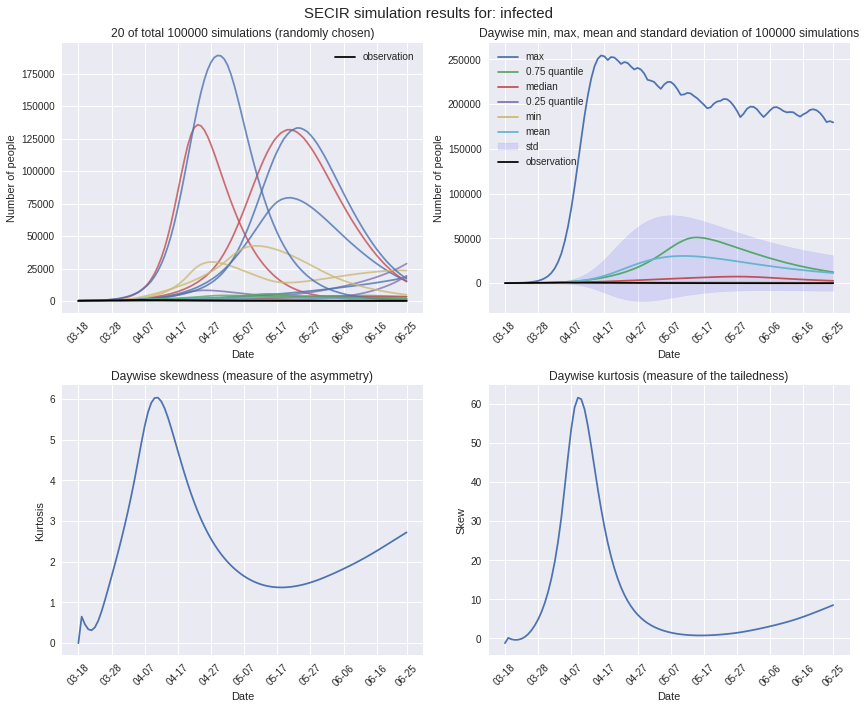

In [270]:
output_no = 0
number_of_days_to_show = 100

outputArray = np.array(sim_out[:2*N, :number_of_days_to_show, output_no])
output_subset = outputArray[randidx, :]
# compute "peak" of every simulation - take variance over this

output_compartment = compartments[static_params['output_index'][output_no]]

show_output_distribution(output_all = outputArray, 
                         ids_to_plot = randidx, 
                         output_compartment = output_compartment,
                         alpha_sim = 0.8,
                         observation_data = dataset[:number_of_days_to_show, output_no],
                        )

As we will see, the third, fourth, and higher standardized moments quantify the relative and absolute tailedness of distributions.  In such cases, we do not care about how spread out a distribution is, but rather how the mass is distributed along the tails.

Now we analyze the distribution of the maximum of infections. For this, the infection peak of each simulation output (i.e. the maximum of the infection numbers in the predicted time period) is calculated. 

In [201]:
df_infection_peak = pd.DataFrame({"infection_peak": np.max(outputArray, axis = 1)})

df_infection_peak_summary = df_infection_peak.describe()
df_infection_peak_summary.loc['var']=[np.var(np.max(outputArray, axis = 1)) ]
df_infection_peak_summary.loc['kurtosis']=[scipy.stats.kurtosis(np.max(outputArray, axis = 1)) ]
df_infection_peak_summary.loc['skew']=[scipy.stats.skew(np.max(outputArray, axis = 1)) ]
df_infection_peak_summary.style.format("{:.2f}")

,infection_peak
count,100000.00
mean,49187.60
std,58060.91
min,120.01
25%,1524.50
50%,15796.36
75%,92262.59
max,254322.39
var,3371035288.46
kurtosis,-0.31


In [204]:
output_names

['max infected', 'max dead', 'mse infected', 'mse dead', 'mean infected']

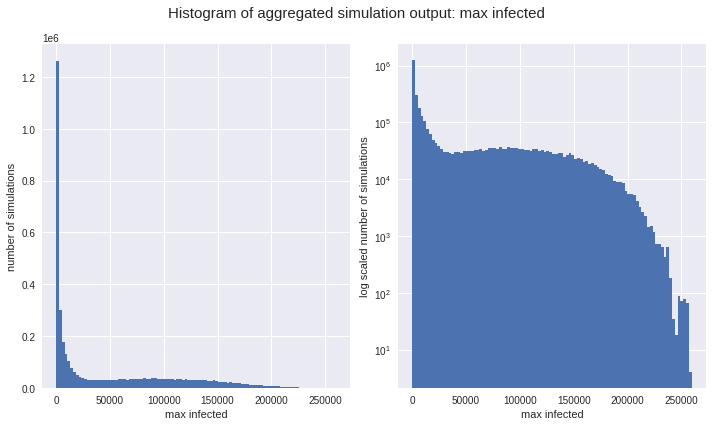

In [218]:
number_of_days_to_show = 100
out = aggregate_output(aggregation_function = 'max', output_no = 0, number_of_days = number_of_days_to_show)
show_histogram_aggregated_output(output_agg = out, aggregation_function = output_names[0])

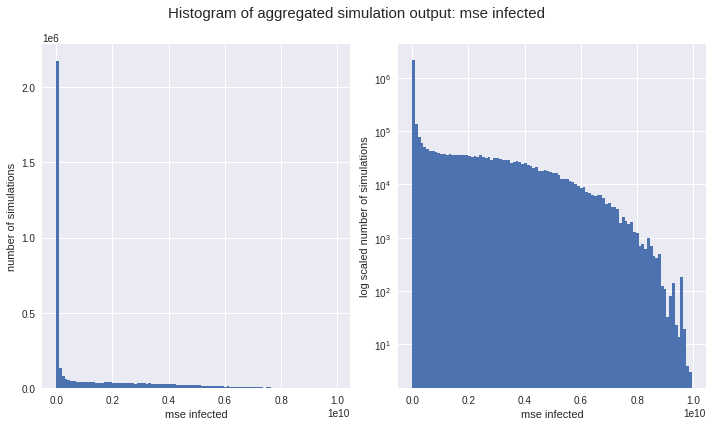

In [223]:
number_of_days_to_show = 100
out = aggregate_output(aggregation_function = 'mse', output_no = 0, number_of_days = number_of_days_to_show)
show_histogram_aggregated_output(output_agg = out, aggregation_function = output_names[2])

In [224]:
out.shape

(4100000, 1)

In [202]:

df_infection_mse = pd.DataFrame({"mse": out})

df_infection_mse_summary = df_infection_peak.describe()
df_infection_mse_summary.loc['var']=[np.var(out) ]
df_infection_mse_summary.loc['kurtosis']=[scipy.stats.kurtosis(out]) ]
df_infection_mse_summary.loc['skew']=[scipy.stats.skew(out]) ]
df_infection_mse_summary.style.format("{:.2f}")

,infection_peak
count,100000.00
mean,355.52
std,191.48
min,36.64
25%,222.55
50%,316.29
75%,440.63
max,2689.13
var,36664.37
kurtosis,4.89


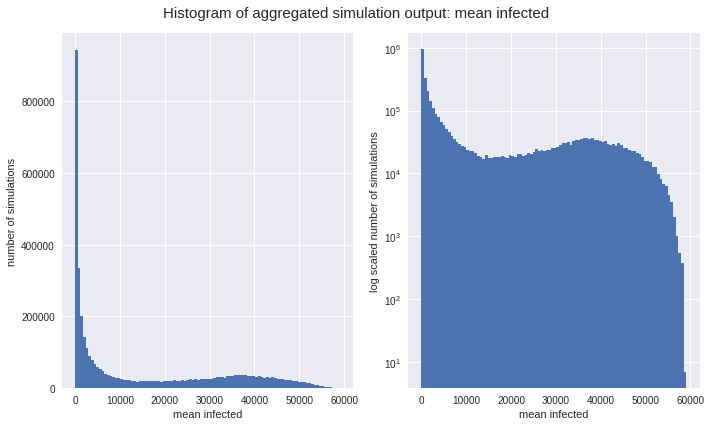

In [222]:
number_of_days_to_show = 100
out = aggregate_output(aggregation_function = 'mean', output_no = 0, number_of_days = number_of_days_to_show)
show_histogram_aggregated_output(output_agg = out, aggregation_function = output_names[-1])

# Predictions of number of deaths

In [207]:
n_outputs = 20# must be smaller than 2N

randidx = np.sort(np.random.randint(0, 2*N, n_outputs))

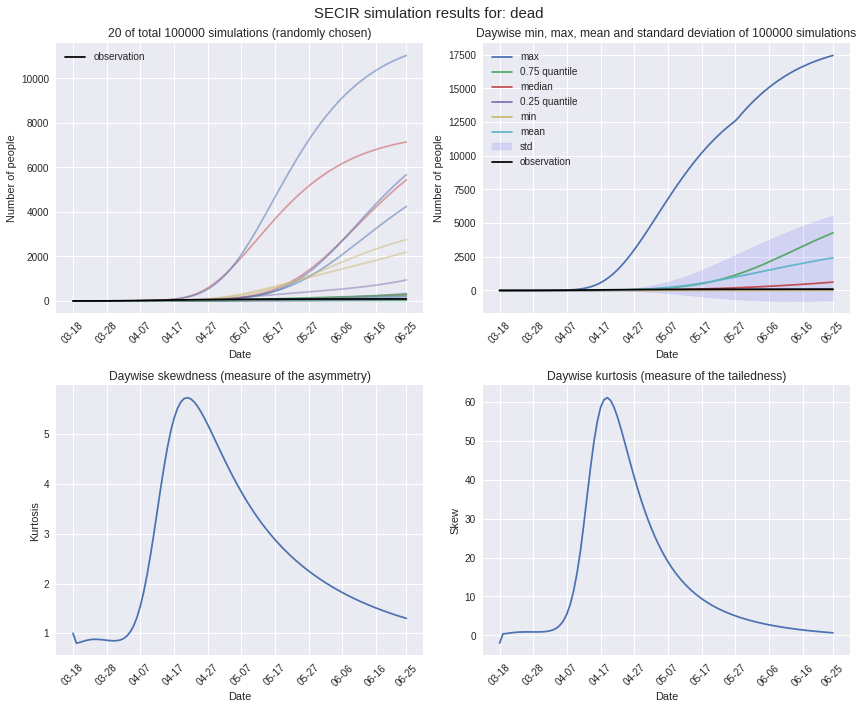

In [208]:
output_no = 1
number_of_days_to_show = 100

outputArray = np.array(sim_out[:2*N, :number_of_days_to_show, output_no])
output_subset = outputArray[randidx, :]
# compute "peak" of every simulation - take variance over this

output_compartment = compartments[static_params['output_index'][output_no]]

show_output_distribution(output_all = outputArray + dataset[0, 1], 
                         ids_to_plot = randidx, 
                         output_compartment = output_compartment,
                         alpha_sim = 0.5,
                         observation_data = dataset[:number_of_days_to_show, output_no],
                        )

Now we analyze the distribution of the maximum of death (i.e. the number of dead people on the last day). For this, the infection peak of each simulation output (i.e. the maximum of the infection numbers in the predicted time period) is calculated.

In [209]:
df_max_dead = pd.DataFrame({"max dead": np.max(outputArray, axis = 1)})

df_max_dead_summary = df_max_dead.describe()
df_max_dead_summary.loc['var']=[np.var(np.max(outputArray, axis = 1)) ]
df_max_dead_summary.loc['kurtosis']=[scipy.stats.kurtosis(np.max(outputArray, axis = 1)) ]
df_max_dead_summary.loc['skew']=[scipy.stats.skew(np.max(outputArray, axis = 1)) ]
df_max_dead_summary.style.format("{:.2f}")

,max dead
count,100000.00
mean,2418.35
std,3149.61
min,3.20
25%,98.50
50%,620.76
75%,4278.90
max,17442.56
var,9919916.27
kurtosis,0.66


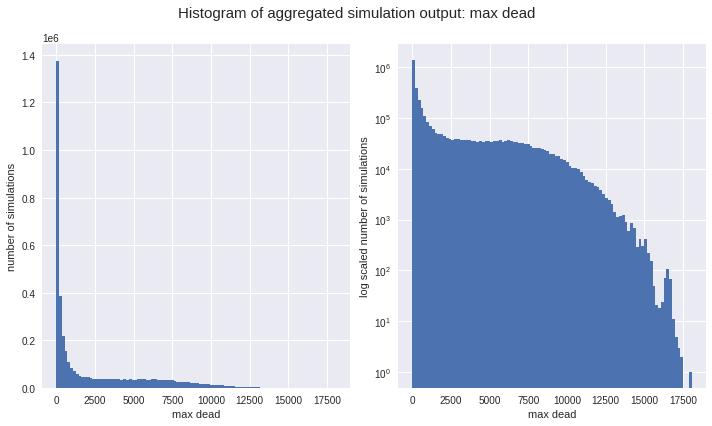

In [225]:
number_of_days_to_show = 100
aggregation_function = 'max'
output_no = 1
out = aggregate_output(aggregation_function = aggregation_function, output_no = output_no, number_of_days = number_of_days_to_show)
output_label = get_output_name(aggregation_function, output_no)
show_histogram_aggregated_output(output_agg = out, aggregation_function = output_label)

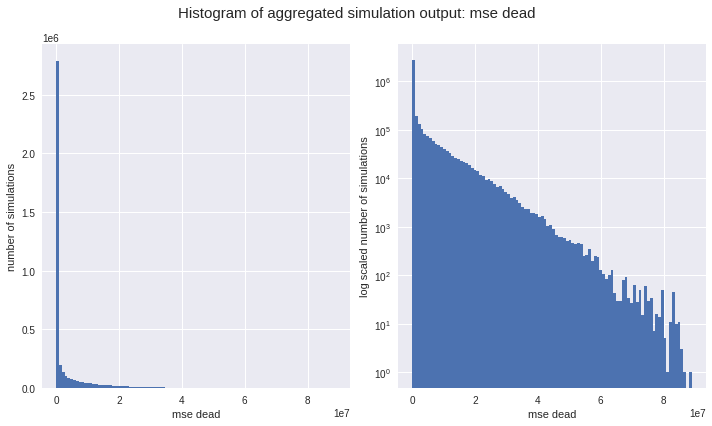

In [226]:
number_of_days_to_show = 100
aggregation_function = 'mse'
output_no = 1
out = aggregate_output(aggregation_function = aggregation_function, output_no = output_no, number_of_days = number_of_days_to_show)
output_label = get_output_name(aggregation_function, output_no)
show_histogram_aggregated_output(output_agg = out, aggregation_function = output_label)